In [2]:
using PyPlot
using QuPhys;

In [2]:
# Define lattice 
Nx, Ny = 2, 3
latt = Lattice(Nx=Nx, Ny=Ny)

# Define lr-space dimensions
N_cut = 2         # Number of states of each mode
N_modes = latt.N  # Number of modes
N = N_cut^N_modes # Total number of states
M = Nx*Ny+1       # Number of states in the LR basis

# Define lr states. Take as initial state all spins up. All other N states are taken as those with miniman Hamming distance to the initial state.
ϕ = Vector{QuantumObject{Vector{ComplexF64}, KetQuantumObject}}(undef, M)
ϕ[1] = kron(repeat([basis(2,0)],N_modes)...)

global i=1
for j in 1:N_modes
    global i+=1
    i<=M && (ϕ[i] = mb(sp, j, latt) * ϕ[1])
end
for k in 1:N_modes-1
    for l=k+1:N_modes
        global i+=1
        i<=M && (ϕ[i] = mb(sp, k, latt) * mb(sp, l, latt) * ϕ[1])
    end
end
for i in i+1:M
    ϕ[i] = QuantumObject(rand(ComplexF64,size(ϕ[1])[1]), dims=ϕ[1].dims)
    normalize!(ϕ[i])
end

# Define initial state
z  = hcat(broadcast(x->x.data, ϕ)...)
p0 = 0. # Population of the lr states other than the initial state
B  = Matrix(Diagonal([1+0im; p0 * ones(M-1)]))
S  = z'*z # Overlap matrix
B = B / tr(S*B) # Normalize B

ρ = QuantumObject(z*B*z', dims=ones(Int,N_modes)*N_cut); # Full density matrix

In [3]:
# Define Hamiltonian and collapse operators
Jx = 0.9 
Jy = 1.04
Jz = 1. 
hx = 0.
γ  = 1

Sx = sum([mb(sx, i, latt) for i in 1:latt.N])
Sy = sum([mb(sy, i, latt) for i in 1:latt.N])
Sz = sum([mb(sz, i, latt) for i in 1:latt.N])
SFxx = sum([mb(sx, i, latt) * mb(sx, j, latt) for i in 1:latt.N for j in 1:latt.N])

H, c_ops = TFIM(Jx, Jy, Jz, hx, γ, latt; bc=pbc, order=1)
e_ops = (Sx,Sy,Sz,SFxx)

tl = LinRange(0,10,100);

In [4]:
# Full evolution
@time mesol = mesolve(H, ρ, tl, c_ops; e_ops=[e_ops...]);
A = Matrix(mesol.states[end].data)
λ = eigvals(Hermitian(A))
Strue  = -sum(λ.*log2.(λ))/latt.N;

  1.910179 seconds (4.83 M allocations: 340.867 MiB, 5.89% gc time, 94.42% compilation time)


In [5]:
# Define functions to be evaluated during the low-rank evolution

function f_purity(p,z,B)
    N  = p.N
    M  = p.M
    S  = p.S
    T  = p.temp_MM

    mul!(T, S, B)
    tr(T^2)
end

function f_trace(p,z,B)
    N  = p.N
    M  = p.M
    S  = p.S
    T  = p.temp_MM

    mul!(T,S,B)
    tr(T)
end

function f_entropy(p,z,B)
    C = p.A0
    σ = p.Bi

    mul!(C, z, sqrt(B))
    mul!(σ, C', C)
    λ = eigvals(Hermitian(σ))
    λ = λ[λ.>1e-10]
    return -sum(λ .* log2.(λ))
end;

In [6]:
# Define the options for the low-rank evolution

opt = LRMesolveOptions( 
    alg        = Tsit5(),
    err_max    = 1e-3,
    p0         = 0.,
    atol_inv   = 1e-6,
    adj_condition="variational",
    Δt = 0.
);

@time lrsol = lr_mesolve(H, z, B, tl, c_ops; e_ops=e_ops, f_ops=(f_purity, f_entropy, f_trace,), opt=opt);

Progress: 100%
 13.566518 seconds (40.83 M allocations: 3.443 GiB, 6.46% gc time, 67.20% compilation time)


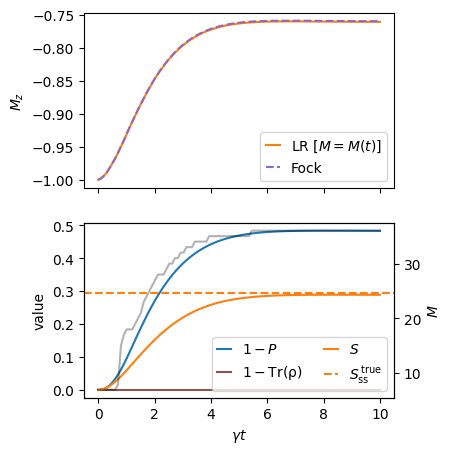

In [7]:
fig,ax = subplots(2,1, figsize=(4,5), sharex=true)

m_me = real(mesol.expect[3,:])/Nx/Ny
m_lr = real(lrsol.expvals[3,:])/Nx/Ny

ax[1].plot(tl, m_lr, "C1", label=raw"LR $[M=M(t)]$")
ax[1].plot(tl, m_me, "C4", ls="--", label="Fock")
ax[1].legend(handlelength=1, )
ax[1].set_ylabel(L"M_{z}")

for axx in ax[2:end]
    ax1 = axx.twinx()
    ax1.plot(tl, lrsol.M, "k", alpha=0.3)
    ax1.set_ylabel(L"M")
end

purity  = real(lrsol.funvals[1,:])
entropy = real(lrsol.funvals[2,:])
trace   = real(lrsol.funvals[3,:])

ax[2].plot(tl, 1 .-purity, label=L"$1-P$")
ax[2].plot(tl, 1 .-trace, c="C5", label=L"$1-\rm{Tr}(\rho)$")
ax[2].plot(tl, entropy/Nx/Ny, c="C1", label=L"S")
ax[2].axhline(Strue, color="C1", ls="--", lw=1.5, label=L"S^{\rm \,true}_{\rm ss}")

ax[2].legend(handlelength=1, ncols=2, columnspacing=1.5, loc="lower right")
ax[2].set_ylabel("value")
ax[2].set_xlabel(L"\gamma t");

In [11]:
all(abs.((m_me .- m_lr)./m_me).<0.1)

true

In [19]:
S_lr = real(lrsol.funvals[2,end])/latt.N
abs((S_lr - Strue)/Strue) < 0.1

true